In [2]:
import h5py
import gc_utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC


In [3]:
simulation = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"

proc_file = sim_dir + simulation + "/" + simulation + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

In [5]:
snap_pub_dir = sim_dir + "/snapshot_times_public.txt"
snap_pub_data = pd.read_table(snap_pub_dir, comment="#", header=None, sep=r"\s+")
snap_pub_data.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

In [ ]:
it = 0
snap = 294

it_id = gc_utils.iteration_name(it)
snap_id = gc_utils.snapshot_name(snap)

props = ["inc", "lz_norm", "r", "form_time", "ecc", "logm_tform"]
prop_locs = ["snap", "snap", "snap", "sour", "snap", "sour"]
prop_scale = ["linear", "linear", "log", "linear", "linear", "linear"]

prop_dict = {"in_situ_s": {}, "in_situ_d": {}, "ex_situ_s": {}, "ex_situ_d": {}}

sour_dat = proc_data[it_id]["source"]
ana_mask = sour_dat["analyse_flag"][()] == 1

src_gc_ids = sour_dat["gc_id"][ana_mask]
src_grp_ids = sour_dat["group_id"][ana_mask]
src_tdis_s = sour_dat["t_dis"][ana_mask]

snap_dat = proc_data[it_id]["snapshots"][snap_id]
acc_mask = snap_dat["now_accreted"][()] == 1
snp_gc_ids = snap_dat["gc_id"][acc_mask]

is_lst = []
id_lst = []
es_lst = []
ed_lst = []

for gcid in snp_gc_ids:
    gc_idx = np.where(src_gc_ids == gcid)[0][0]
    grp = src_grp_ids[gc_idx]
    tdis = src_tdis_s[gc_idx]

    if (grp == 0) & (tdis < 0):
        is_lst.append(gcid)

    elif (grp == 0) & (tdis > 0):
        id_lst.append(gcid)

    elif (grp != 0) & (tdis < 0):
        es_lst.append(gcid)

    elif (grp != 0) & (tdis > 0):
        ed_lst.append(gcid)


prop_dict["in_situ_s"]["gcid"] = np.array(is_lst)
prop_dict["in_situ_d"]["gcid"] = np.array(id_lst)
prop_dict["ex_situ_s"]["gcid"] = np.array(es_lst)
prop_dict["ex_situ_d"]["gcid"] = np.array(ed_lst)

for gc_type in prop_dict.keys():
    for prop, prop_loc in zip(props, prop_locs):
        prop_lst = []
        if prop_loc == "sour":
            for gcid in prop_dict[gc_type]["gcid"]:
                gcid_idx = np.where(sour_dat["gc_id"][ana_mask] == gcid)[0][0]
                prop_lst.append(sour_dat[prop][ana_mask][gcid_idx])

        else:
            for gcid in prop_dict[gc_type]["gcid"]:
                gcid_idx = np.where(snap_dat["gc_id"] == gcid)[0][0]
                prop_lst.append(snap_dat[prop][gcid_idx])

        prop_dict[gc_type][prop] = np.array(prop_lst)

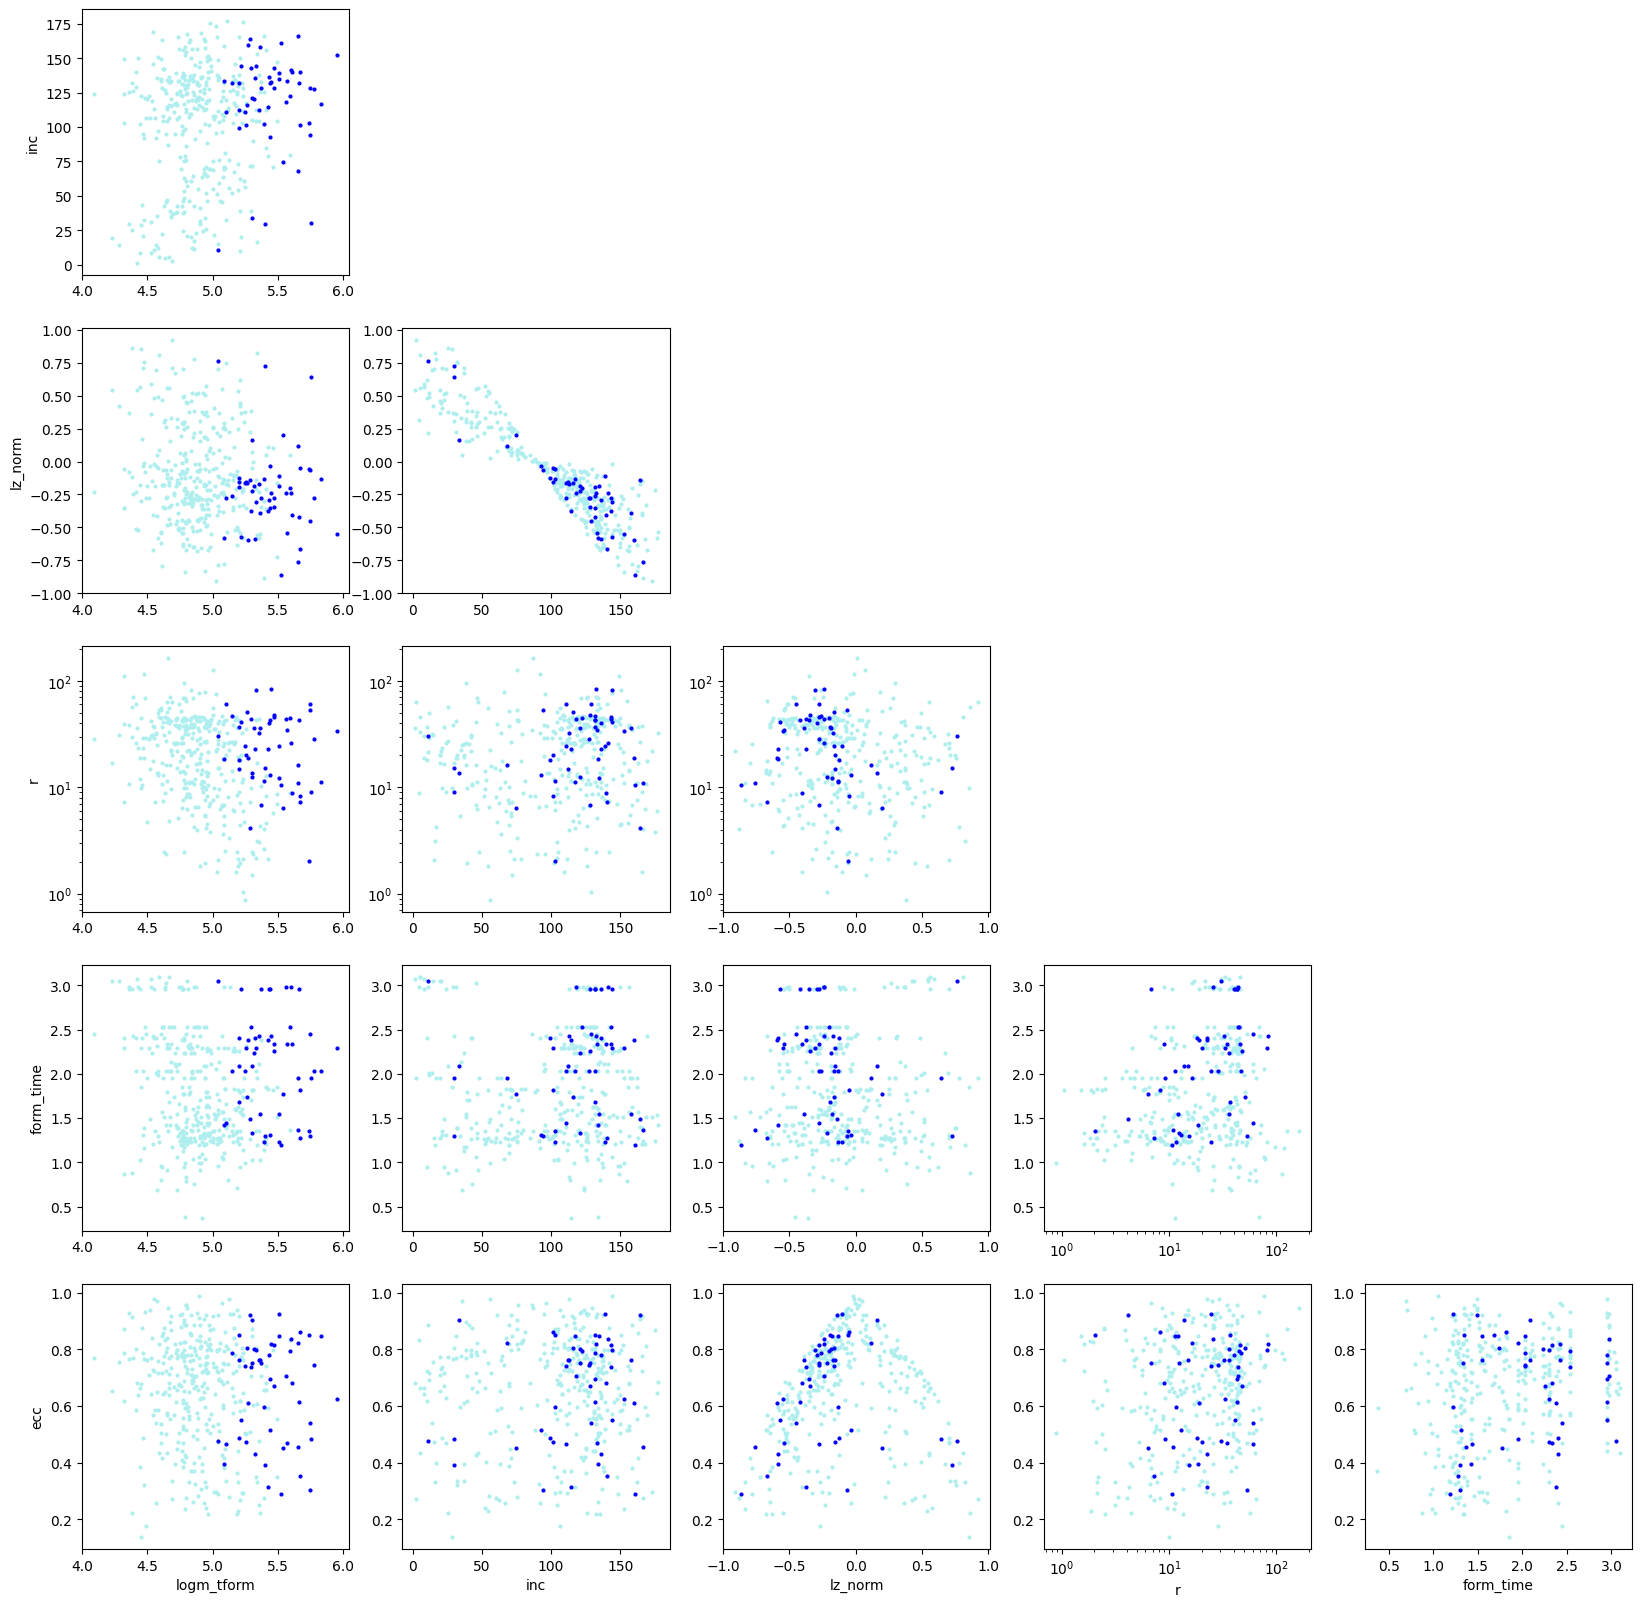

In [7]:
num_rows = len(props) - 1
num_cols = len(props) - 1

type_check = ["in_situ_s", "in_situ_d", "ex_situ_s", "ex_situ_d"]
type_check = ["in_situ_s", "in_situ_d"]
type_check = ["ex_situ_s", "ex_situ_d"]

plot_c = ["r", "pink", "blue", "paleturquoise"]
plot_m = [".", ".", ".", "."]
plot_s = [4, 4, 4, 4]
plot_z = [1, 0, 1, 0]

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# for i, ax in enumerate(axs.flat):
for (i, j), ax in np.ndenumerate(axs):
    if j > i:
        ax.axis("off")

    else:
        prop_x = props[j - 1]
        x_scale = prop_scale[j - 1]

        prop_y = props[i]
        y_scale = prop_scale[i]

        for type_i, gc_type in enumerate(prop_dict.keys()):
            if gc_type in type_check:
                xd = prop_dict[gc_type][prop_x]
                yd = prop_dict[gc_type][prop_y]

                ax.scatter(xd, yd, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
                ax.set_xscale(x_scale)
                ax.set_yscale(y_scale)

        if i == num_rows - 1:
            ax.set_xlabel(prop_x)

        if j == 0:
            ax.set_ylabel(prop_y)


In [8]:
for gc_type in prop_dict.keys():
    pos_lst = []
    for gcid in prop_dict[gc_type]["gcid"]:
        gcid_idx = np.where(snap_dat["gc_id"] == gcid)[0][0]
        pos_lst.append(snap_dat["pos.xyz"][gcid_idx])

    prop_dict[gc_type]["pos.xyz"] = np.array(pos_lst)

Text(0, 0.5, 'y [kpc]')

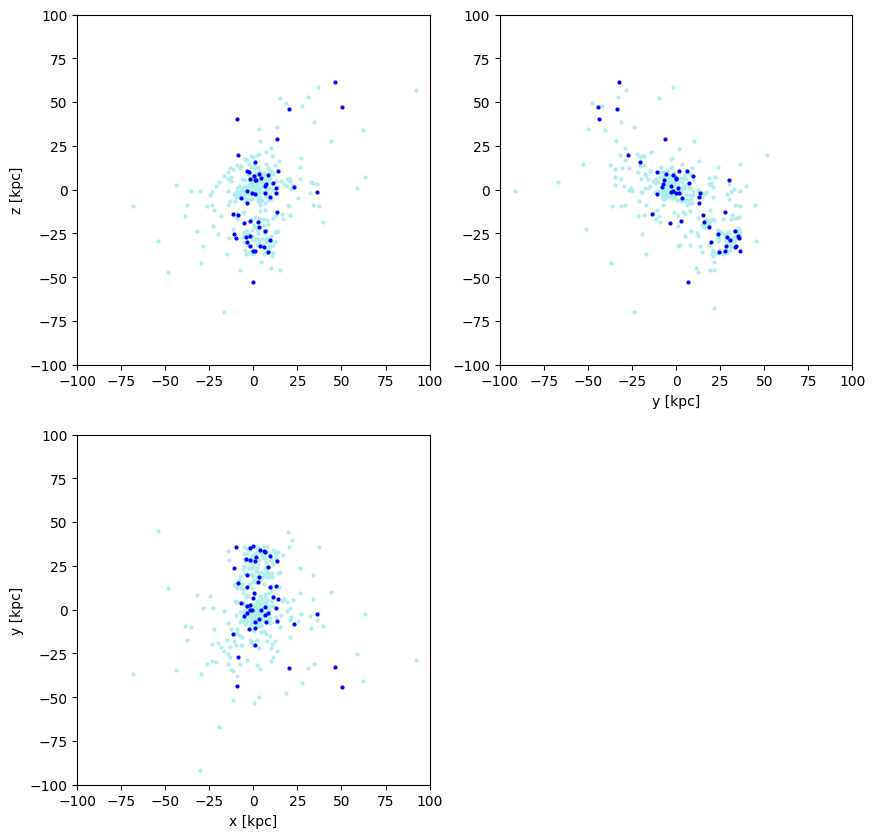

In [9]:
type_check = ["in_situ_s", "in_situ_d", "ex_situ_s", "ex_situ_d"]
type_check = ["in_situ_s", "in_situ_d"]
type_check = ["ex_situ_s", "ex_situ_d"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for type_i, gc_type in enumerate(prop_dict.keys()):
    if gc_type in type_check:
        pos_xyz = prop_dict[gc_type]["pos.xyz"]
        xd = pos_xyz[:, 0]
        yd = pos_xyz[:, 1]
        z = pos_xyz[:, 2]

        axs[0, 0].scatter(xd, z, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
        axs[0, 1].scatter(yd, z, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
        axs[1, 0].scatter(xd, yd, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])

for ax in axs.flat:
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])

axs[1, 1].axis("off")

axs[0, 1].set_xlabel("y [kpc]")
axs[1, 0].set_xlabel("x [kpc]")

axs[0, 0].set_ylabel("z [kpc]")
axs[1, 0].set_ylabel("y [kpc]")

In [10]:
for gc_type in prop_dict.keys():
    tdis_lst = []
    tfor_lst = []
    for gcid in prop_dict[gc_type]["gcid"]:
        gcid_idx = np.where(sour_dat["gc_id"][ana_mask] == gcid)[0][0]
        tdis_lst.append(sour_dat["t_dis"][ana_mask][gcid_idx])
        tfor_lst.append(sour_dat["form_time"][ana_mask][gcid_idx])

    prop_dict[gc_type]["t_dis"] = np.array(tdis_lst)
    prop_dict[gc_type]["form_time"] = np.array(tfor_lst)

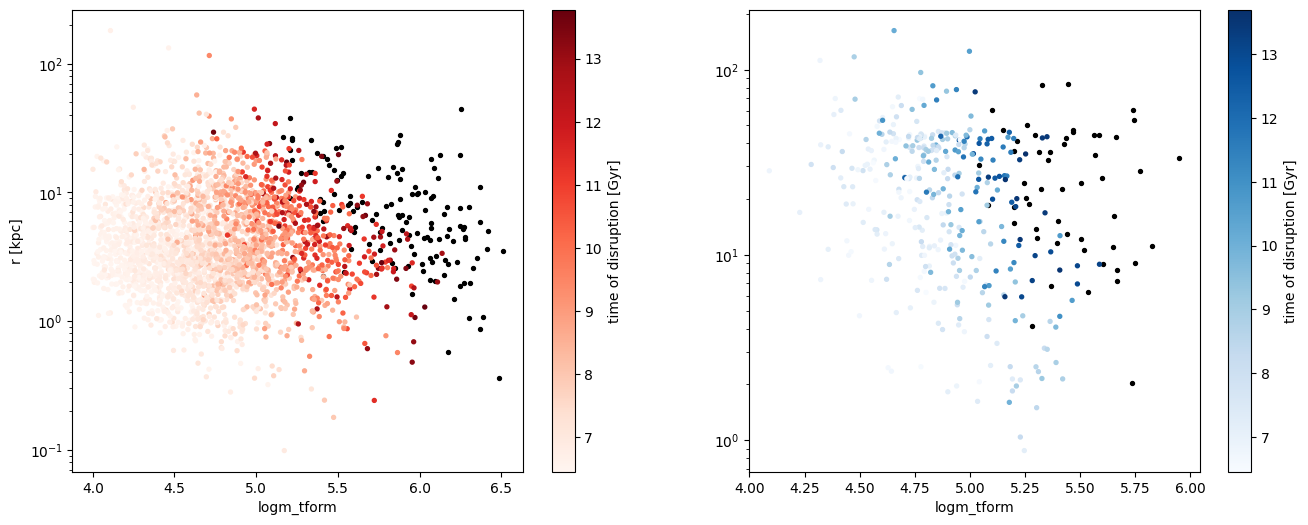

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(wspace=0.2, hspace=0.2)

sd = [None, None]
for type_i, gc_type in enumerate(prop_dict.keys()):
    if "in" in gc_type:
        i = 0
        cmap = "Reds"
    else:
        i = 1
        cmap = "Blues"

    tdis_mask = prop_dict[gc_type]["t_dis"] > 0

    xd = prop_dict[gc_type]["logm_tform"][tdis_mask]
    yd = prop_dict[gc_type]["r"][tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][tdis_mask]

    sd[i] = axs[i].scatter(xd, yd, c=cd, cmap=cmap, s=8)

    xd = prop_dict[gc_type]["logm_tform"][~tdis_mask]
    yd = prop_dict[gc_type]["r"][~tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][~tdis_mask]

    axs[i].scatter(xd, yd, s=8, c="k")

for i in [0, 1]:
    if sd[i] is not None:
        fig.colorbar(sd[i], ax=axs[i], label="time of disruption [Gyr]")

axs[0].set_xlabel("logm_tform")
axs[1].set_xlabel("logm_tform")

axs[0].set_ylabel("r [kpc]")

axs[0].set_yscale("log")
axs[1].set_yscale("log")

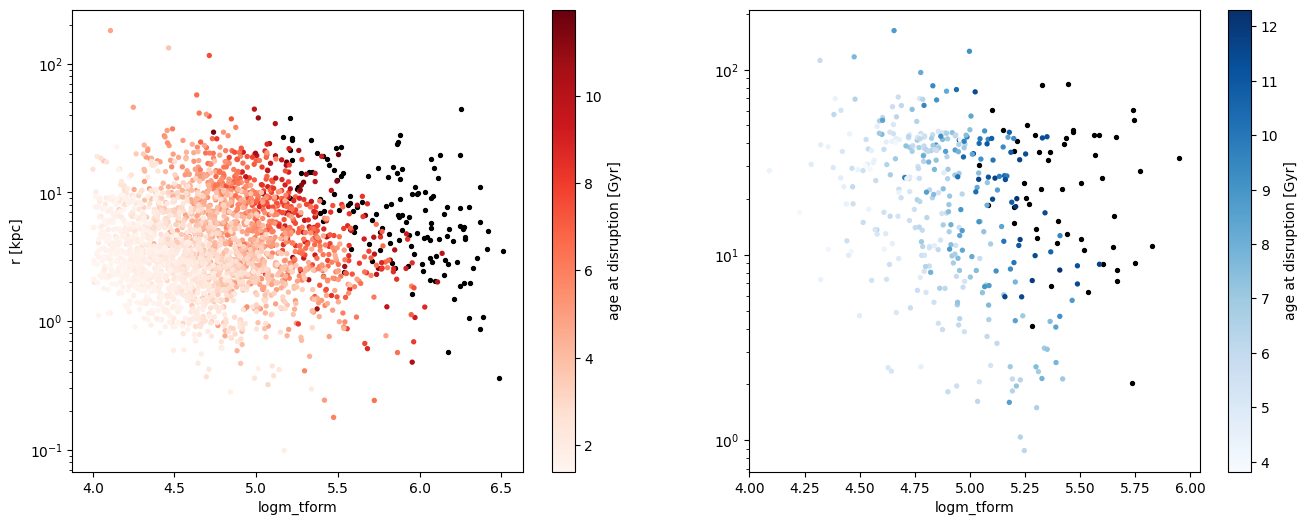

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(wspace=0.2, hspace=0.2)

sd = [None, None]
for type_i, gc_type in enumerate(prop_dict.keys()):
    if "in" in gc_type:
        i = 0
        cmap = "Reds"
    else:
        i = 1
        cmap = "Blues"

    tdis_mask = prop_dict[gc_type]["t_dis"] > 0

    xd = prop_dict[gc_type]["logm_tform"][tdis_mask]
    yd = prop_dict[gc_type]["r"][tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][tdis_mask] - prop_dict[gc_type]["form_time"][tdis_mask]

    sd[i] = axs[i].scatter(xd, yd, c=cd, cmap=cmap, s=8)

    xd = prop_dict[gc_type]["logm_tform"][~tdis_mask]
    yd = prop_dict[gc_type]["r"][~tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][~tdis_mask] - prop_dict[gc_type]["form_time"][~tdis_mask]

    axs[i].scatter(xd, yd, s=8, c="k")

for i in [0, 1]:
    if sd[i] is not None:
        fig.colorbar(sd[i], ax=axs[i], label="age at disruption [Gyr]")

axs[0].set_xlabel("logm_tform")
axs[1].set_xlabel("logm_tform")

axs[0].set_ylabel("r [kpc]")

axs[0].set_yscale("log")
axs[1].set_yscale("log")

In [33]:
prop_dict

{'in_situ_s': {'gcid': array([ 57057454,  49867717,  55759176,  46186812, 122776884, 123320985,
         116120128,  59979388,  55423942, 120191241, 125266350, 120023067,
         122603231, 130489547, 123142986,  52458546,  56897591,  43418483,
          40439938,  41228010,  38644983,  40235324,  50619748,  63157402,
          60812016,  37454970,  62406382,  31197781,  31007272,  47163753,
          47167726, 120387214, 131619861, 123493678,  41437444,  29506016,
          53693303,  54217192,  28913647,  57383658,  63632998,  42422709,
          53519711,  63040046,  60528775,  48935478,  52628708,  46987529,
          53710136,  59836441,  58494168,  43823869,  47958652,  65190203,
          56263403,  42424654,  49861991,  54413992,  44993624,  53832160,
          41224412,  49481634,  43630354,  25788646,  36091406,  51928397,
          40226424,  64972218,  31805891,  59817768,  54722315,  31433681,
          30099921,  48516193,  57046513,  33107905,  64655503,  48940394,
    

In [36]:
prop_dict["in_situ_s"].keys()

dict_keys(['gcid', 'inc', 'lz_norm', 'r', 'form_time', 'ecc', 'logm_tform', 'pos.xyz', 't_dis'])

In [77]:
in_s_m = 10 ** prop_dict["in_situ_s"]["logm_tform"]
in_s_r = prop_dict["in_situ_s"]["r"]

in_d_m = 10 ** prop_dict["in_situ_d"]["logm_tform"]
in_d_r = prop_dict["in_situ_d"]["r"]

X_s_fit = np.stack((np.log10(in_s_m), np.log10(in_s_r)), axis=1)
X_d_fit = np.stack((np.log10(in_d_m), np.log10(in_d_r)), axis=1)

X_s_plot = np.stack((in_s_m, in_s_r), axis=1)
X_d_plot = np.stack((in_d_m, in_d_r), axis=1)

X_fit = np.vstack((X_s_fit, X_d_fit))
X_plot = np.vstack((X_s_plot, X_d_plot))

y = np.array([0] * len(X_s_fit) + [1] * len(X_d_fit))

log10(y) = -1.697 * log10(x) + 10.393


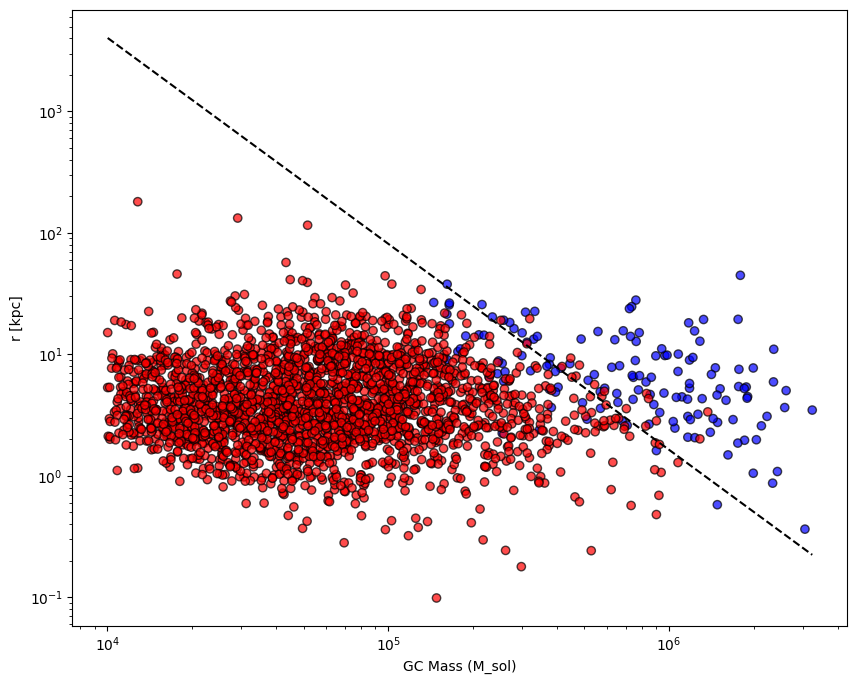

In [82]:
# Fit linear SVM
clf = SVC(kernel="linear")
clf.fit(X_fit, y)

# Get decision boundary parameters
w = clf.coef_[0]
b = clf.intercept_[0]

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, cmap="bwr", edgecolor="k", alpha=0.7)

# Create decision boundary line
x_vals = np.linspace(X_fit[:, 0].min(), X_fit[:, 0].max(), 100)
y_vals = -(w[0] * x_vals + b) / w[1]
plt.plot(10**x_vals, 10**y_vals, "k--", label="Decision boundary (SVM)")

plt.xlabel("GC Mass (M_sol)")
plt.ylabel("r [kpc]")

plt.xscale("log")
plt.yscale("log")

# Print final form of the linear fit in log space
m = -w[0] / w[1]
c = -b / w[1]
print(f"log10(y) = {m:.3f} * log10(x) + {c:.3f}")

In [14]:
proc_data.close()